# Task-5: Credit card fraud detection

## Importing Libraries

In [3]:
#General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Importing data

In [5]:
df=pd.read_csv("creditcard.csv")

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Missing value check

In [10]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No missing values in data

## EDA

### Outliers check

In [14]:
def count_outliers_iqr(df):
    outlier_counts = {}
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return pd.Series(outlier_counts).sort_values(ascending=False)

outlier_counts = count_outliers_iqr(df)
outlier_counts

V27       39163
Amount    31904
V28       30342
V20       27770
V8        24134
V6        22965
V23       18541
V12       15348
V21       14497
V14       14149
V2        13526
V5        12295
V4        11148
V19       10205
V10        9496
V7         8948
V9         8283
V16        8184
V18        7533
V17        7420
V1         7062
V26        5596
V25        5367
V24        4774
V13        3368
V3         3363
V15        2894
V22        1317
V11         780
Class       492
Time          0
dtype: int64

We are not concerned with outliers in the V1,V2 etc columns as they are likely principle components being used in the data.
We are more interested to see if the outliers in the "Amount" column amounts to anything interesting

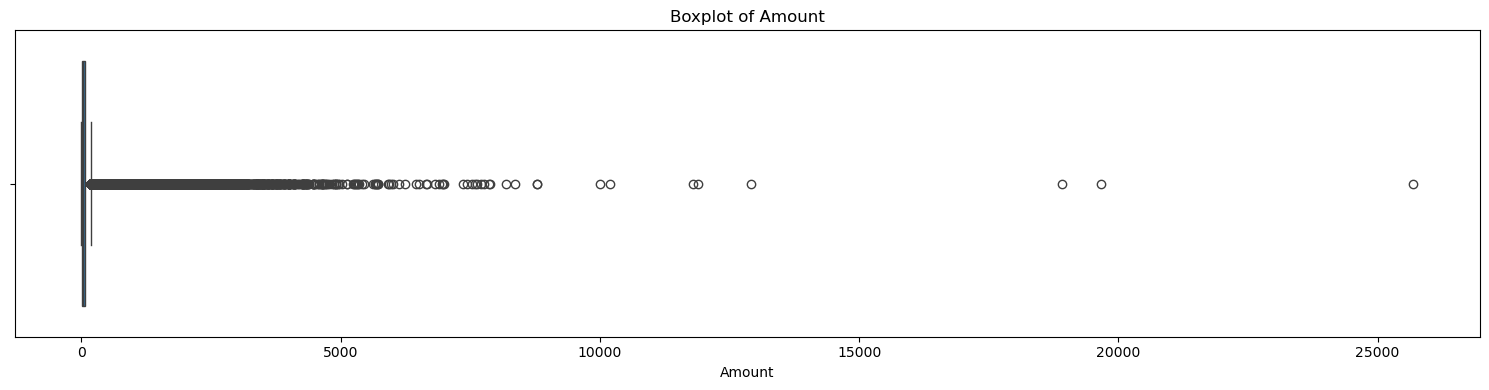

In [16]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df['Amount'], orient='h')
plt.title('Boxplot of Amount')
plt.xlabel('Amount')
plt.tight_layout()
plt.show()

A lot of anomalous withdrawals are there. We want to see if these high amounts are related to frauds in anyways.

In [18]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Outlier Amounts analysis

In [20]:
df = df.sort_values(by='Time').reset_index(drop=True)
df['Time_Diff'] = df['Time'].diff().fillna(0)

high_amount_thresh = 1000  
low_time_thresh = 60       

df['High_Amount'] = df['Amount'] > high_amount_thresh
df['Low_TimeDiff'] = df['Time_Diff'] < low_time_thresh

summary = df.groupby(['High_Amount', 'Low_TimeDiff'])['Class'].mean().unstack()
print("Fraud Rate Table:")
print(summary)

Fraud Rate Table:
Low_TimeDiff      True
High_Amount           
False         0.001714
True          0.003061


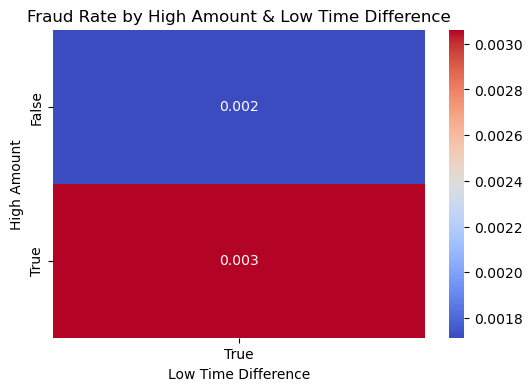

In [21]:
plt.figure(figsize=(6, 4))
sns.heatmap(summary, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Fraud Rate by High Amount & Low Time Difference')
plt.xlabel('Low Time Difference')
plt.ylabel('High Amount')
plt.show()

In [22]:
high_amount_frauds = df[(df['Amount'] > high_amount_thresh) & (df['Class'] == 1)]
print("Count of high-amount frauds:", high_amount_frauds.shape[0])

Count of high-amount frauds: 9


We see that the the rate of fraud increases by almost 56% when time difference becomes low(<1 min)

### Feature Importance

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
X = df.drop(columns=['Class',"High_Amount","Time_Diff"])
y = df['Class']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(20))

   Feature  Importance
12     V12    0.137163
14     V14    0.133758
17     V17    0.120065
10     V10    0.091301
11     V11    0.085747
16     V16    0.065880
9       V9    0.040955
4       V4    0.027755
18     V18    0.025493
7       V7    0.020720
26     V26    0.018971
21     V21    0.017060
6       V6    0.017002
3       V3    0.016301
20     V20    0.015579
1       V1    0.015168
5       V5    0.012823
19     V19    0.012518
8       V8    0.012439
29  Amount    0.012353


We keep only top 20 features. Then we use PCA and FACTOR ANALYSIS to further create more feautres

### PCA(on reduced data)

In [32]:
top_20_features = importance_df.head(20)['Feature'].tolist()
df_20 = df[top_20_features]

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_20)


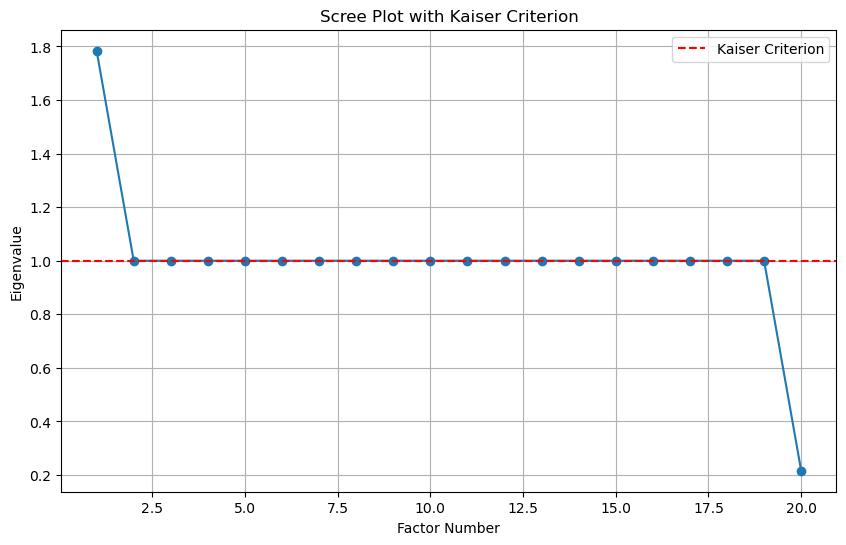

Number of factors to retain (Kaiser Criterion): 19


In [34]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)
eigenvalues = pca.explained_variance_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.axhline(y=1, color='r', linestyle='--', label='Kaiser Criterion')
plt.title('Scree Plot with Kaiser Criterion')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.show()

n_factors = sum(eigenvalues > 1)
print(f'Number of factors to retain (Kaiser Criterion): {n_factors}')

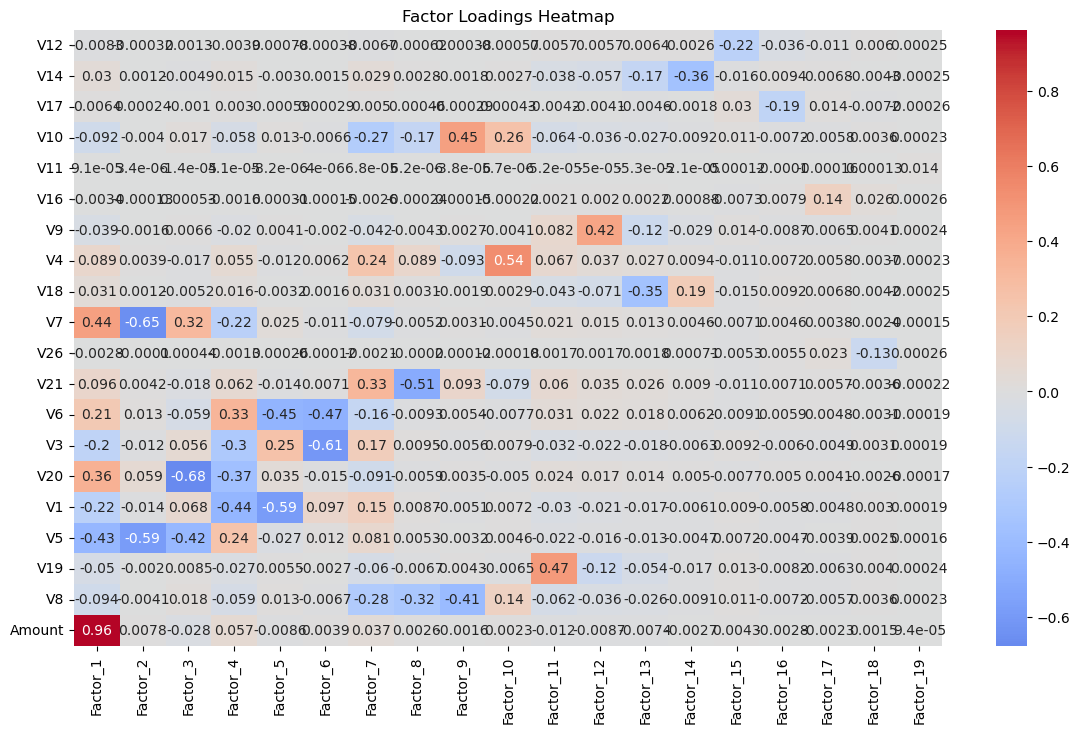

In [35]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=n_factors)
X_factors = fa.fit_transform(X_scaled)  

loadings = fa.components_
loadings_df = pd.DataFrame(loadings.T, index=df_20.columns, columns=[f'Factor_{i+1}' for i in range(n_factors)])

plt.figure(figsize=(14, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title('Factor Loadings Heatmap')
plt.show()

### New feature data frame

In [37]:
X = pd.DataFrame(X_factors, columns=[f'Factor_{i+1}' for i in range(n_factors)])

## Train - Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Selection

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

In [42]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\nModel: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    if y_prob is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

In [43]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    evaluate_model(model, name)


Model: Logistic Regression
[[56852    12]
 [   36    62]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.92      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9746
F1 Score: 0.7209

Model: Random Forest
[[56860     4]
 [   18    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9579
F1 Score: 0.8791

Model: K-Nearest Neighbors
[[56857     7]
 [   22    76]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.0

D:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:58:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model: XGBoost
[[56856     8]
 [   23    75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.77      0.83        98

    accuracy                           1.00     56962
   macro avg       0.95      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9714
F1 Score: 0.8287


### Final Model Selection

Final model selected is:<b>Random Forest</b>

<b>Reason:</b>

1. High F1-score: Best for imbalanced dataset. here "Class" is imbalanced(Most are 0).
2. Highest recall: Highest no. of actual frauds predicted.
3. Captures non linear relation using Factor analysis.
4. Not affected by outliers.

### Hyperparameter tuning

In [47]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}



In [48]:
rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [49]:
random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
print("Best Parameters:\n", random_search.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters:
 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [50]:
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


[[56859     5]
 [   18    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9578
F1 Score: 0.8743


## Conclusion

Following hyperparameter tuning of the Random Forest classifier, the model demonstrates good performance for the majority class (Class 0) and a strong improvement for the minority class (Class 1). Below is a detailed breakdown:

Accuracy: The model reached perfect accuracy of 1.00, demonstrating that it predicts the majority class (non-fraud) correctly without any error.

Class 1 Performance (Minority Class):

Precision for Class 1 (fraud): 0.94, i.e., when the model classifies as fraud, it's correct 94% of the time.

Recall for Class 1: 0.82, which is good, but still could be better — it gets around 18% of real fraud cases wrong.

F1 Score for Class 1: 0.87, which finds a good balance between precision and recall.

ROC AUC Score: 0.9578, reflecting the model's capacity to distinguish between fraud and non-fraud with strong confidence.

## Final prediction

In [86]:
pred=best_rf.predict(X)
results=pd.DataFrame({"Amount":df["Amount"],"Actual":df["Class"],"Prediction":pred})
results

,Amount,Actual,Prediction
0,149.62,0,0
1,2.69,0,0
2,378.66,0,0
3,123.50,0,0
4,69.99,0,0
...,...,...,...
284802,0.77,0,0
284803,24.79,0,0
284804,10.00,0,0
284805,67.88,0,0
